In [1]:
!pip install -qU fsspec datasets transformers huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 18.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset

In [3]:
batch_size = 16
lr = 5e-5
epochs = 2
temperature = 1.0
alpha_soft = 0.5
max_len = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
raw = load_dataset("tweet_eval", "sentiment")

README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
raw

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
raw['train'][0]

{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 'label': 2}

In [7]:
raw['train'].features

{'text': Value('string'),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'])}

In [16]:
label_features = raw['train'].features['label']
num_labels = len(label_features.names)
print(f"Label name: {label_features.names}")
print(f"Label length: {num_labels}")

Label name: ['negative', 'neutral', 'positive']
Label length: 3


In [9]:
train = raw['train'].shuffle(seed=42).select(range(3000))
val   = raw['validation'].shuffle(seed=42).select(range(300))

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=max_len)

In [12]:
tokenized_data = {}

tokenized_data['train'] = train.map(tokenize, batched=True, remove_columns=['text'])
tokenized_data['val'] = val.map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [13]:
collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [14]:
train_loader = DataLoader(tokenized_data['train'], batch_size=16, shuffle=True, collate_fn=collator)
val_loader = DataLoader(tokenized_data['val'], batch_size=16, shuffle=True, collate_fn=collator)

In [36]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=num_labels).to(device)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-large-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [37]:
student_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to(device)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [38]:
## Freeze Teacher model (no training)

for params in teacher_model.parameters():
  params.requires_grad = False

In [39]:
len(teacher_model.state_dict().keys())

393

In [40]:
len(student_model.state_dict().keys())

201

In [41]:
teacher_model.eval()
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [42]:
from transformers import get_scheduler

optimizer = optim.AdamW(student_model.parameters(), lr=lr)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epochs * len(train_loader),
)

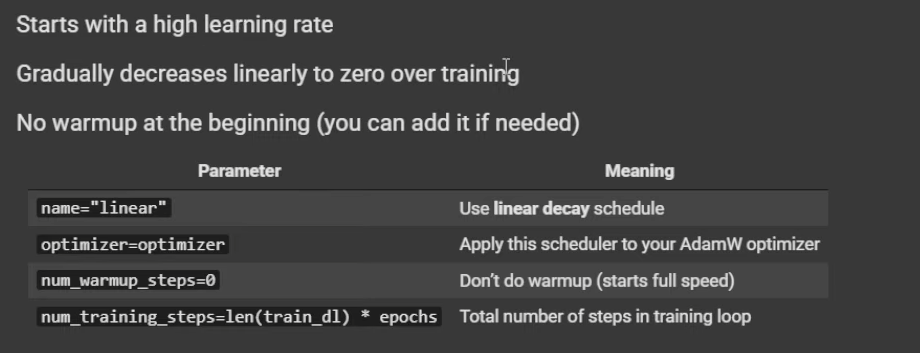

In [43]:
from tqdm.auto import tqdm

def distill():
  student_model.train()
  pbar = tqdm(train_loader, desc="Training")
  for batch in pbar:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    ## Teacher prediction (soft targets)
    with torch.no_grad():
      t_logits = teacher_model(input_ids, attention_mask).logits
      t_soft = torch.softmax(t_logits / temperature, dim=1)

    ## Student prediction
    s_logits = student_model(input_ids, attention_mask).logits
    s_soft = torch.softmax(s_logits / temperature, dim=1)

    ## Distillation + CE Loss
    loss_soft = kl_loss(s_soft, t_soft) * (temperature ** 2)
    loss_hard = ce_loss(s_soft, labels)
    loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    pbar.set_postfix({"loss": f"{loss.item():.4f}"})

In [48]:
def evaluate():
  student_model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      out = student_model(input_ids, attention_mask).logits
      pred = out.argmax(dim=1)
      correct += (pred == labels).sum().item()
      total += labels.size(0)
  return correct / total * 100

In [45]:
for epoch in range(1, epochs+1):
  distill()
  acc = evaluate()
  print(f"Epoch {epoch}/{epochs}, Validation Accuracy: {acc:.2f}%")

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2, Validation Accuracy: 64.33%


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2, Validation Accuracy: 63.00%


In [46]:
student_model.save_pretrained("distilled_student_model")
tokenizer.save_pretrained("distilled_student_model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('distilled_student_model/tokenizer_config.json',
 'distilled_student_model/tokenizer.json')

In [47]:
test = load_dataset("tweet_eval", "sentiment", split="test[:1000]")
tokenized = test.map(tokenize, batched=True, remove_columns=["text"])
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_loader = DataLoader(tokenized, batch_size=batch_size, shuffle=False, collate_fn=collator)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [70]:
from sklearn.metrics import accuracy_score
import time

def predict_and_evaluate(model, name, loader):
  model.eval()
  all_preds, all_labels = [], []
  start_time = time.time()

  with torch.no_grad():
    for batch in loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask).logits
      preds = logits.argmax(dim=1)

      all_preds.extend(preds.cpu().tolist())
      all_labels.extend(labels.cpu().tolist())

  total_time = time.time() - start_time
  avg_time = total_time / len(loader)
  accuracy = accuracy_score(all_labels, all_preds)

  print(f"Model: {name}\n")
  print(f"Accuracy: {accuracy*100:.2f} %")
  print(f"Total Inference Time: {total_time:.2f} seconds")
  print(f"Average Inference Time: {avg_time:.4f} seconds")

In [71]:
predict_and_evaluate(student_model, "Distilled Student Model (bert-base-uncased)", test_loader)

Model: Distilled Student Model (bert-base-uncased)

Accuracy: 52.50 %
Total Inference Time: 2.70 seconds
Average Inference Time: 0.0428 seconds


In [72]:
predict_and_evaluate(teacher_model, "Teacher Model (bert-large-uncased)", test_loader)

Model: Teacher Model (bert-large-uncased)

Accuracy: 22.60 %
Total Inference Time: 8.87 seconds
Average Inference Time: 0.1408 seconds


In [73]:
model = AutoModelForSequenceClassification.from_pretrained("distilled_student_model")
tokenizer = AutoTokenizer.from_pretrained("distilled_student_model")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [74]:
model.push_to_hub("ArpitKadam/Distilled-Bert-Base-Model")
tokenizer.push_to_hub("ArpitKadam/Distilled-Bert-Base-Model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...iz5dyz_/model.safetensors:   0%|          | 14.2kB /  438MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ArpitKadam/Distilled-Bert-Base-Model/commit/f94ec21d00342cf5664de6373306e72ff1ce0c62', commit_message='Upload tokenizer', commit_description='', oid='f94ec21d00342cf5664de6373306e72ff1ce0c62', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ArpitKadam/Distilled-Bert-Base-Model', endpoint='https://huggingface.co', repo_type='model', repo_id='ArpitKadam/Distilled-Bert-Base-Model'), pr_revision=None, pr_num=None)